In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


%matplotlib inline
# Plot the LDA-transformed training data in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [36]:
data.GroupID.value_counts()

1    75
0    67
Name: GroupID, dtype: int64

# Machine Learning 
### 12/1/2018

## Goals
* Feature Subset Selection
* Preprocessing
* Handle class imbalance
* 3 problems: cvp, iva, mvp
* training average and std dev of accuracy, sensitivity, specificity, ppv and npv

## MSA vs PSP
### Logistic Regression

In [82]:
# Get the data
data = pd.read_csv('MSAvsPSP_Training.csv')
y = data['GroupID']
X = data.drop(['GroupID'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25)

In [81]:
k = 10

pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('LR', LogisticRegression())])))
pipelines.append(('Ridge', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('LR', RidgeClassifier())])))
pipelines.append(('SVM', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('SVM', SVC())])))
pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('KNN', KNeighborsClassifier())])))
pipelines.append(('GNB', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('GNB', GaussianNB())])))
pipelines.append(('ADA', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('ADA', AdaBoostClassifier())])))
pipelines.append(('GBC', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('GBC', GradientBoostingClassifier())])))
pipelines.append(('RFC', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('RFC', RandomForestClassifier())])))
pipelines.append(('ETC', Pipeline([('Scaler', StandardScaler()),('Norm', Normalizer()),('PCA', PCA(n_components=15)),('ETC', ExtraTreesClassifier())])))

results = []
names = []

accs = []
for name, model in pipelines:
    kfold = KFold(n_splits='all', random_state=42)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(X_train, Y_train)

    print("Holdout:")
    predictions = model.predict(X_test)

    H_acc = accuracy_score(Y_test, predictions)
    print(H_acc)
    print(confusion_matrix(Y_test, predictions))
    print(classification_report(Y_test, predictions))
    print()
    

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Standardized)')
ax = fig.add_subplot(111)
bp_dict = plt.boxplot(results)
ax.set_xticklabels(names)

# for idx, line in enumerate(bp_dict['boxes']):
#     x, y = line.get_xydata()[0] # bottom of left line
#     plt.text(x+.25,y-0.005, 'H:%.2f' % accs[idx][0],
#          horizontalalignment='center', # centered
#          verticalalignment='top')
plt.show()

ValueError: The number of folds must be of Integral type. all of type <class 'str'> was passed.

In [43]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


def unidirectional_grid_search_optimization(model, parameter, parameter_range, X, y, cv=5, scoring='accuracy'):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, {parameter: parameter_range}, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    means = clf.cv_results_['mean_test_score']

    plt.figure()
    plot = plt.plot(parameter_range, means, color='black')
    plt.title(parameter)
    plt.show()
    return clf

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy'):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2


import pandas as pd
import numpy as np

# Get the data
data = pd.read_csv('MSAvsPSP_Training.csv')
y = data['GroupID']
X = data.drop(['GroupID'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# parameters and ranges to plot
param_grid = {
    "classifier__penalty": ['l1', 'l2'],
    "classifier__C": np.logspace(-5, 0, 30),
    "fss__k": range(1,117,2)
}

clf = Pipeline([
    ('fss', SelectKBest()),
    ('standardization', StandardScaler()),
    ('classifier', LogisticRegression(random_state = 84))
])

best1 = grid_search_optimization(clf, param_grid, X_train, Y_train, X_test, Y_test)

# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 3480 candidates, totalling 17400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1679 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6179 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 12479 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 17400 out of 17400 | elapsed:  1.7min finished


Best parameters set found on development set:

{'classifier__C': 0.018873918221350976, 'classifier__penalty': 'l2', 'fss__k': 111}

Grid scores on development set:

0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 1}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 3}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 5}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 7}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 9}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 11}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 13}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__

In [57]:
b1 = best1.best_estimator_.fit(X_train, Y_train)
b1.score(X_test, Y_test)

0.66666666666666663

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2


import pandas as pd
import numpy as np

# Get the data
data = pd.read_csv('MSAvsPSP_Training.csv')
y = data['GroupID']
X = data.drop(['GroupID'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# parameters and ranges to plot
param_grid = {
    "classifier__penalty": ['l1', 'l2'],
    "classifier__C": np.logspace(-5, 0, 30),
    "fss__k": range(1,117,2)
}

clf = Pipeline([
    ('fss', SelectKBest()),
    ('standardization', StandardScaler()),
    ('Norm', Normalizer()),
    ('classifier', LogisticRegression(random_state = 84))
])

best2 = grid_search_optimization(clf, param_grid, X_train, Y_train, X_test, Y_test)


# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 3480 candidates, totalling 17400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2155 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 6655 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 12955 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 17400 out of 17400 | elapsed:   34.0s finished


Best parameters set found on development set:

{'classifier__C': 1.0, 'classifier__penalty': 'l2', 'fss__k': 111}

Grid scores on development set:

0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 1}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 3}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 5}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 7}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 9}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 11}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 13}
0.453 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 15}
0.453 (+/

0.66666666666666663

In [67]:
b2 = best2.best_estimator_.fit(X_train, Y_train)
b2.score(X_test, Y_test)

0.69444444444444442

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2


import pandas as pd
import numpy as np

# Get the data
data = pd.read_csv('MSAvsPSP_Training.csv')
y = data['GroupID']
X = data.drop(['GroupID'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# parameters and ranges to plot
param_grid = {
    "classifier__penalty": ['l1', 'l2'],
    "classifier__C": np.logspace(-5, 0, 30),
    "fss__k": range(31,117,2),
    "PCA__n_components": range(2,32)
}

clf = Pipeline([
    ('fss', SelectKBest()),
    ('standardization', StandardScaler()),
    ('Norm', Normalizer()),
    ('PCA', PCA()),
    ('classifier', LogisticRegression(random_state = 84))
])

best3 = grid_search_optimization(clf, param_grid, X_train, Y_train, X_test, Y_test)
b3 = best1.best_estimator_.fit(X_train, Y_train)
b3.score(X_test, Y_test)

# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 77400 candidates, totalling 387000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4388 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8588 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 13988 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 20588 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 28388 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 37388 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 47588 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 58988 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 71588 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 85388 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 100388 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 116588 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 133988 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 152588 tasks  

Best parameters set found on development set:

{'PCA__n_components': 19, 'classifier__C': 1.0, 'classifier__penalty': 'l2', 'fss__k': 115}

Grid scores on development set:

0.453 (+/-0.004) for {'PCA__n_components': 2, 'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 31}
0.453 (+/-0.004) for {'PCA__n_components': 2, 'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 33}
0.453 (+/-0.004) for {'PCA__n_components': 2, 'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 35}
0.453 (+/-0.004) for {'PCA__n_components': 2, 'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 37}
0.453 (+/-0.004) for {'PCA__n_components': 2, 'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 39}
0.453 (+/-0.004) for {'PCA__n_components': 2, 'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1', 'fss__k': 41}
0.453 (+/-0.004) for {'PCA__n_components': 2, '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'classifier__penalty': 'l1', 'fss__k': 37}
0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'classifier__penalty': 'l1', 'fss__k': 39}
0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'classifier__penalty': 'l1', 'fss__k': 41}
0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'classifier__penalty': 'l1', 'fss__k': 43}
0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'classifier__penalty': 'l1', 'fss__k': 45}
0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'classifier__penalty': 'l1', 'fss__k': 47}
0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'classifier__penalty': 'l1', 'fss__k': 49}
0.453 (+/-0.004) for {'PCA__n_components': 22, 'classifier__C': 0.0025929437974046669, 'c

In [70]:
b3 = best3.best_estimator_.fit(X_train, Y_train)
b3.score(X_test, Y_test)

0.69444444444444442

Try logistic regression with recursive feature subset selection`

Optimal number of features : 74


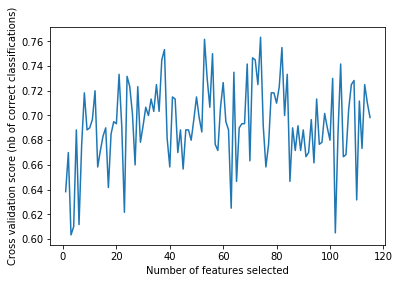

In [92]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=StratifiedKFold(50),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()